## FLARE and MONAI Integration
[MONAI](https://monai.io/) allows the definition of AI models using the "bundle" concept. It allows for easy experimentation and sharing of models that have been developed using MONAI. Using the bundle configurations, we can use MONAI's MonaiAlgo (the implementation of ClientAlgo) to execute a bundle model in a federated scenario using NVFlare.

<img src="images/MONAI-FL.svg" alt="MONAI FL Integration" width=400/>

You can find the code for the [MONAI Integration code](https://github.com/NVIDIA/NVFlare/blob/main/integration/monai/README.md) in the `integration` directory of the NVFlare GitHub.

There is also an example that walks through preparing the environment and input datasets, and running the [MONAI Spleen CT Segmentation example](https://github.com/NVIDIA/NVFlare/tree/main/integration/monai/examples/spleen_ct_segmentation_local) using a locally provisioned secure deployment.  We'll walk through that here.

## Preparing the notebook environment
Before you proceeding on this notebook, please make sure you have activated the virtual environment nvflare_example.
And have installed monai_nvflare inside the environment.

Please make sure to register the kernel.

You can follow instructions in [Examples Readme](https://github.com/NVIDIA/NVFlare/blob/main/examples/README.md#set-up-a-virtual-environment)

Please also make sure to switch the top right kernel to "nvflare_example".

In [10]:
# Install monai[all] for this notebook and verify monai and nvflare installed
%pip install "monai[all]>=1.3.1"
%pip list | grep "nvflare"
%pip list | grep "monai"

Note: you may need to restart the kernel to use updated packages.
nvflare                            2.7.1
Note: you may need to restart the kernel to use updated packages.
monai                              1.5.1
Note: you may need to restart the kernel to use updated packages.


## Preparing the POC environment
Before running the POC, there are a couple important environment variables that should be set.

First, to simplify deploying the example apps in the NVFlare GitHub repo, you can set `NVFLARE_HOME` to the root of the GitHub clone.  In this case, we've cloned to our current working directory, so we can set it as:

In [11]:
import os
workdir=os.getcwd()
%env NVFLARE_HOME={workdir}/../../../NVFlare

env: NVFLARE_HOME=/home/esl/NVFlare/integration/monai/../../../NVFlare


By default, POC mode uses a temporary workspace in /tmp/nvflare/poc.  We would like to keep the workspace within our working directory, so let's create a poc_workspace dir.  We can then use the `NVFLARE_POC_WORKSPACE` variable to define this as the POC workspace.

In [12]:
# clean up monai_poc_workspace
!rm -rf monai_poc_workspace
!mkdir monai_poc_workspace
%env NVFLARE_POC_WORKSPACE={workdir}/monai_poc_workspace

env: NVFLARE_POC_WORKSPACE=/home/esl/NVFlare/integration/monai/monai_poc_workspace


### Preparing the POC workspace

Now that we've configured our POC environment, we can prepare the POC workspace.  By default, this will generate POC packages for a server and two clients.

(Note that `nvflare poc prepare` prompts you to create the workspace.)

In [13]:
!printf '%s\n' y | nvflare poc prepare

prepare poc at /home/esl/NVFlare/integration/monai/monai_poc_workspace for 2 clients
This will delete poc workspace directory: '/home/esl/NVFlare/integration/monai/monai_poc_workspace' and create a new one. Is it OK to proceed? (y/N) provision at /home/esl/NVFlare/integration/monai/monai_poc_workspace for 2 clients with /home/esl/NVFlare/integration/monai/monai_poc_workspace/project.yml
INFO: Generated results can be found under /home/esl/NVFlare/integration/monai/monai_poc_workspace/example_project/prod_00. 
link job directory from /home/esl/NVFlare/examples to /home/esl/NVFlare/integration/monai/monai_poc_workspace/example_project/prod_00/admin@nvidia.com/transfer


Let's take a look.

In [14]:
!ls -aR monai_poc_workspace | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//──/g' -e 's/─/├/' -e '$s/├/└/'

monai_poc_workspace
├─data
├─example_project
├───prod_00
├─────admin@nvidia.com
├───────local
├───────startup
├─────server
├───────local
├───────startup
├───────transfer
├─────site-1
├───────local
├───────startup
├───────transfer
├─────site-2
├───────local
├───────startup
├───────transfer
└───state


### Running the POC Deployment

When starting the POC deployment, it's necessary to use a separate terminal since the `nvflare poc start` command will run  in the foreground emitting output from the server and any connected clients.

Also note that `nvflare poc start` starts all participants, including the admin console.  It's often nice to start server and clients separately so that we can interact with the deployment using a separate admin console.  To do this, we'll pass the `-ex admin` arg to exclude the admin client from the initial POC run and use the FLARE API to run admin commands separately.

So pop open the launcher, launch a terminal, and run (remembering to set the NVFLARE_POC_WORKSPACE and NVFLARE_HOME vars!):

```shell
export NVFLARE_POC_WORKSPACE=$(pwd -P)/monai_poc_workspace
export NVFLARE_HOME=$(pwd -P)/../../../NVFlare
nvflare poc start -ex admin@nvidia.com
```

Keep this terminal open so you can continue to watch server and client output.

## Setting up the MONAI example

The MONAI example for a distributed deployment can be found in the `NVFlare/integration/monai/examples/spleen_ct_segmentation_local` directory.

We now need to download the MONAI bundle that contains the `spleen_ct_segmentation` model and configuration.  We can do this using the MONAI bundle download built-in script.

This model and configuration will be part of the FLARE spleen_ct_segmentation_local app that is deployed to the FLARE clients, so we'll provde the job directory as the bundle download path.

We will also download the example spleen dataset and push it to a directory accessible by the containers running the FLARE clients.

In [15]:
%env JOB_DIR=examples/spleen_ct_segmentation_local/jobs/spleen_ct_segmentation_local
!python3 -m monai.bundle download \
    --name "spleen_ct_segmentation" \
    --version "0.5.7" \
    --bundle_dir ./${JOB_DIR}/app/config
!if [ ! -d data/Task09_Spleen ]; then \
    python3 examples/spleen_ct_segmentation_local/download_spleen_dataset.py; fi
#!for site in site-1 site-2; do mkdir monai_poc_workspace/${site}/data; cp -r data/Task09_Spleen monai_poc_workspace/${site}/data; done
!sed -i "s,/workspace/data/Task09_Spleen,${PWD}/data/Task09_Spleen,g" ${JOB_DIR}/app/config/spleen_ct_segmentation/configs/train.json

env: JOB_DIR=examples/spleen_ct_segmentation_local/jobs/spleen_ct_segmentation_local
2025-11-30 17:06:26,189 - INFO - --- input summary of monai.bundle.scripts.download ---
2025-11-30 17:06:26,189 - INFO - > name: 'spleen_ct_segmentation'
2025-11-30 17:06:26,189 - INFO - > version: '0.5.7'
2025-11-30 17:06:26,189 - INFO - > bundle_dir: './examples/spleen_ct_segmentation_local/jobs/spleen_ct_segmentation_local/app/config'
2025-11-30 17:06:26,189 - INFO - > source: 'monaihosting'
2025-11-30 17:06:26,189 - INFO - > remove_prefix: 'monai_'
2025-11-30 17:06:26,189 - INFO - > progress: True
2025-11-30 17:06:26,189 - INFO - ---


2025-11-30 17:06:26,440 - INFO - Expected md5 is None, skip md5 check for file examples/spleen_ct_segmentation_local/jobs/spleen_ct_segmentation_local/app/config/spleen_ct_segmentation_v0.5.7.zip.
2025-11-30 17:06:26,441 - INFO - File exists: examples/spleen_ct_segmentation_local/jobs/spleen_ct_segmentation_local/app/config/spleen_ct_segmentation_v0.5.7.zip, skipped 

## Running the MONAI app
Now that we have the example spleen segmentation app in `examples/spleen_ct_segmentation_local` and the MONAI bundle config in the `job/app/config` subdirectory, we can look at how we configure the job parameters with FLARE MONAI FL integration.

In [16]:
!ls -aR examples/spleen_ct_segmentation_local | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//──/g' -e 's/─/├/' -e '$s/├/└/'

├─spleen_ct_segmentation_local
├───jobs
├─────spleen_ct_segmentation_he
├───────app
├─────────config
├─────spleen_ct_segmentation_local
├───────app
├─────────config
├───────────spleen_ct_segmentation
├─────────────configs
├─────────────docs
├─────────────models
└───workspaces


As with other FLARE applications, we have the usual `config_fed_client.json` and `config_fed_server.json` configurations.  We also have a set of MONAI configs from the MONAI Bundle in `job/app/config/spleen_ct_segmentation/configs`.

The `job/app/config/spleen_ct_segmentation/configs/train.json` defines the MONAI training parameters, for example inputs/output and network definition (you can navigate in the file browser and open the train.json file in the Editor to see the full configuration:

```json
    "bundle_root": "/workspace/data/spleen_ct_segmentation",
    "ckpt_dir": "$@bundle_root + '/models'",
    "output_dir": "$@bundle_root + '/eval'",
    "dataset_dir": "/workspace/data/Task09_Spleen",
    "images": "$list(sorted(glob.glob(@dataset_dir + '/imagesTr/*.nii.gz')))",
    "labels": "$list(sorted(glob.glob(@dataset_dir + '/labelsTr/*.nii.gz')))",
    "val_interval": 5,
    "device": "$torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')",
    "network_def": {
        "_target_": "UNet",
        "spatial_dims": 3,
        "in_channels": 1,
        "out_channels": 2,
        "channels": [
            16,
            32,
            64,
            128,
            256
        ],
        "strides": [
            2,
            2,
            2,
            2
        ],
        "num_res_units": 2,
        "norm": "batch"
    },
```

The MONAI Client executor uses this config along with the parameters in `config_fed_client.json` and `config_fed_server.json` to define the FLARE app.  For example, the client config defines this executor and the number of local training epochs:
```json
{
  "format_version": 2,

  "executors": [
    {
      "tasks": [
        "train", "submit_model", "validate"
      ],
      "executor": {
        "id": "executor",
        "path": "monai_nvflare.client_algo_executor.ClientAlgoExecutor",
        "args": {
          "client_algo_id": "client_algo",
          "key_metric": "val_mean_dice"
        }
      }
    }
  ],

  "task_result_filters": [
  ],
  "task_data_filters": [
  ],

  "components": [
    {
      "id": "client_algo",
      "path": "monai.fl.client.MonaiAlgo",
      "args": {
        "bundle_root": "config/spleen_ct_segmentation",
        "local_epochs": 10
      }
    }
  ]
}
```

Similarly, the server config defines the number of global rounds:
```json
{
  "format_version": 2,

  "min_clients": 2,
  "num_rounds": 100,

  "task_data_filters": [],
  "task_result_filters": [],
  "components": [

  ... <snip> ...
  
  ],
  "workflows": [
      {
        "id": "scatter_gather_ctl",
        "name": "ScatterAndGather",
        "args": {
            "min_clients" : "{min_clients}",
            "num_rounds" : "{num_rounds}",
            "start_round": 0,
            "wait_time_after_min_received": 10,
            "aggregator_id": "aggregator",
            "persistor_id": "persistor",
            "shareable_generator_id": "shareable_generator",
            "train_task_name": "train",
            "train_timeout": 0
        }
  ...
```

### Exercise
The server is configured to for 100 rounds of training, which will take a long time to complete.  Use the file browser to the left to navigate to `examples/spleen_ct_segmentation_local/job/app/config/` and right-click to open `config_fed_server.json` in the Editor.  Change `"num_rounds": 100` to something much smaller, like `"num_rounds": 2`.


### Using the FLARE API to connect and submit the MONAI app

The admin directory contains the startup script for the FLARE Console, which can be used interactively to operate a running FLARE deployment.  A FLARE deployment can also be managed using the FLARE API, which will use the configuration in the admin directory to connect to the FLARE server.  Since we already have the server and clients running in the background from the above terminal commands, we'll use FLARE API to start a new admin session and connect.

To get started, we need to import the FLARE API class and initialize session.

In [18]:
from nvflare.fuel.flare_api.flare_api import new_secure_session

poc_prepared_dir = os.path.join(workdir, "monai_poc_workspace", "example_project/prod_00")
admin_dir = os.path.join(poc_prepared_dir, "admin@nvidia.com")
admin_session = new_secure_session("admin@nvidia.com", startup_kit_location = admin_dir)
print(admin_session.get_system_info())

Connecting to FLARE ...
SystemInfo
server_info:
status: stopped, start_time: Sun Nov 30 17:08:45 2025
client_info:
site-2(last_connect_time: Sun Nov 30 17:08:59 2025)
site-1(last_connect_time: Sun Nov 30 17:09:00 2025)
job_info:




Now with the session connected, we can use the job we've just configured to submit and run the MONAI application.

In [19]:
path_to_job_config = f"{os.getcwd()}/examples/spleen_ct_segmentation_local/jobs/spleen_ct_segmentation_local"
print(path_to_job_config)
job_id = admin_session.submit_job(path_to_job_config)
print(job_id)

/home/esl/NVFlare/integration/monai/examples/spleen_ct_segmentation_local/jobs/spleen_ct_segmentation_local
3482dff5-5219-4e08-8d00-4db1339bd0d7



After the job has been submitted, you can navigate to the terminal that was used to start the POC deployment and see progress messages as the job executes.

You can also use the admin session to query job status as in the previous POC notebook.

In [20]:
import json

# Job Status
jobs_output = admin_session.list_jobs()
jobs_detail = admin_session.list_jobs(detailed=True)
print("Job Status")
print(json.dumps((jobs_output), indent=2))
print("\nJob Detail")
print(json.dumps((jobs_detail), indent=2))

# Job Metadata
print("\nJob Metadata")
admin_session.get_job_meta(job_id)

Job Status
[
  {
    "job_id": "3482dff5-5219-4e08-8d00-4db1339bd0d7",
    "job_name": "spleen_ct_segmentation_local",
    "status": "SUBMITTED",
    "submit_time": "2025-11-30T17:09:13.986358+08:00",
    "duration": "N/A"
  }
]

Job Detail
[
  {
    "name": "spleen_ct_segmentation_local",
    "resource_spec": {},
    "min_clients": 2,
    "deploy_map": {
      "app": [
        "@ALL"
      ]
    },
    "submitter_name": "admin@nvidia.com",
    "submitter_org": "nvidia",
    "submitter_role": "project_admin",
    "job_folder_name": "spleen_ct_segmentation_local",
    "job_id": "3482dff5-5219-4e08-8d00-4db1339bd0d7",
    "submit_time": 1764493753.986358,
    "submit_time_iso": "2025-11-30T17:09:13.986358+08:00",
    "start_time": "",
    "duration": "N/A",
    "data_storage_format": 2,
    "status": "SUBMITTED"
  }
]

Job Metadata


{'name': 'spleen_ct_segmentation_local',
 'resource_spec': {},
 'min_clients': 2,
 'deploy_map': {'app': ['@ALL']},
 'submitter_name': 'admin@nvidia.com',
 'submitter_org': 'nvidia',
 'submitter_role': 'project_admin',
 'job_folder_name': 'spleen_ct_segmentation_local',
 'job_id': '3482dff5-5219-4e08-8d00-4db1339bd0d7',
 'submit_time': 1764493753.986358,
 'submit_time_iso': '2025-11-30T17:09:13.986358+08:00',
 'start_time': '',
 'duration': 'N/A',
 'data_storage_format': 2,
 'status': 'SUBMITTED'}

## Recap

We covered a lot of ground in this tutorial, so let's quickly recap.

MONAI provides a rich set of examples, pretrained models, data loaders, and transforms to streamline medical imaging workflows.  The MONAI Bundle format allows researchers and developers to provide a self-contained bundle that includes model definitions, training and evaluation configurations, along with any pre- and post- processing required to run end-to-end workflows.

MONAI FL integration with NVIDIA FLARE provides reference executors that allow researchers and developers to easily translate a model developed locally using MONAI and packaged in a MONAI Bundle to a Federated Learning paradigm without the overhead of developing a custom federated learning application.

In [23]:
%pip install itkwidgets

I0000 00:00:1764495916.401055  889684 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Note: you may need to restart the kernel to use updated packages.


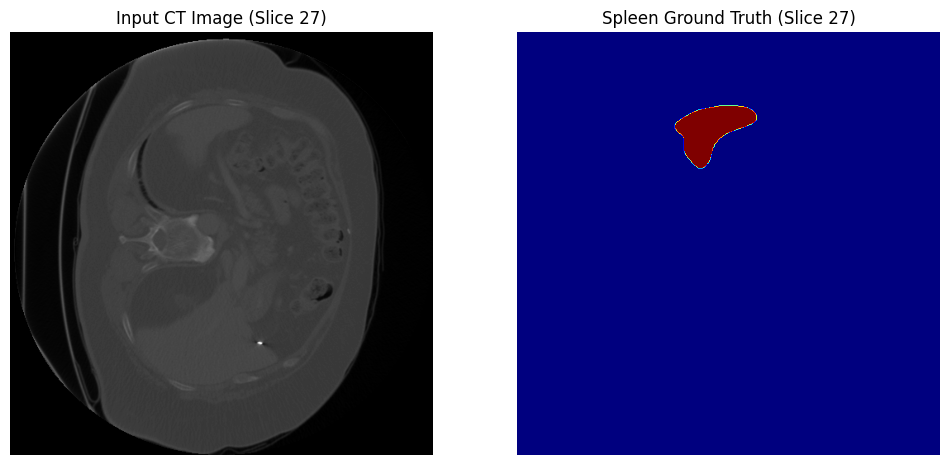

✅ 成功產出結果圖！Federated Learning 模組任務完成。


In [25]:
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import os

# 1. 抓取資料路徑
img_path_list = sorted(glob.glob("data/Task09_Spleen/imagesTr/*.nii.gz"))
lbl_path_list = sorted(glob.glob("data/Task09_Spleen/labelsTr/*.nii.gz"))

if img_path_list:
    # 2. 讀取第一張影像
    # 這裡我們使用 nibabel 讀取，並直接轉成 numpy array
    img = nib.load(img_path_list[0]).get_fdata()
    lbl = nib.load(lbl_path_list[0]).get_fdata()

    # 3. 取中間切片 (Z軸的中間)
    slice_idx = img.shape[2] // 2
    
    plt.figure(figsize=(12, 6))
    
    # 左圖：原始 CT
    plt.subplot(1, 2, 1)
    plt.imshow(img[:, :, slice_idx], cmap="gray")
    plt.title(f"Input CT Image (Slice {slice_idx})")
    plt.axis('off')
    
    # 右圖：脾臟標註 (Label)
    plt.subplot(1, 2, 2)
    plt.imshow(lbl[:, :, slice_idx], cmap="jet") # 使用彩色顯示
    plt.title(f"Spleen Ground Truth (Slice {slice_idx})")
    plt.axis('off')
    
    plt.show()
    print("✅ 成功產出結果圖！Federated Learning 模組任務完成。")
else:
    print("❌ 找不到資料，請確認 data 資料夾路徑。")